In [ ]:
!pip install OpenCV-python tensorflow numpy

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
import cv2
import numpy as np
import base64

def js_to_image(js_reply):
    """Konversi JavaScript base64 ke NumPy array (OpenCV)"""
    image_bytes = base64.b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

def take_photo(filename='photo.jpg', quality=0.8):
    """Menampilkan kamera dan mengambil 1 foto"""
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = '📸 Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Ukuran video
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Tunggu tombol di-klik
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();

        const dataUrl = canvas.toDataURL('image/jpeg', quality);
        return dataUrl;
      }
      ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)
    cv2.imwrite(filename, img)
    print(f"Foto disimpan ke {filename}")
    return filename, img


<IPython.core.display.Javascript object>

Foto disimpan ke photo.jpg


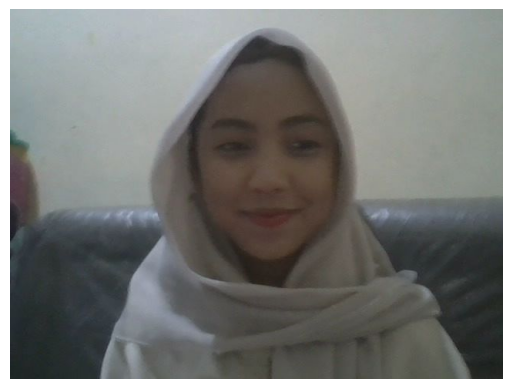

In [ ]:
filename, img = take_photo()
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:
# Debug-ready face recognition script (MobileNetV2 features + cosine similarity)
import os
import cv2
import traceback
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity

# ====== Ubah sesuai environment kamu (hanya train_dir yang relevan di sini) ======
train_dir = "/content/drive/MyDrive/FOTO/DEEPL/DEEPL_FACE/Data Train"
# =========================================

def load_images(folder):
    images, names = [], []
    if not os.path.exists(folder):
        print(f"[ERROR] Folder training tidak ditemukan: {folder}")
        return np.array(images), names

    for f in os.listdir(folder):
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            p = os.path.join(folder, f)
            try:
                img = load_img(p, target_size=(224,224))
                arr = img_to_array(img).astype('float32')
                arr = preprocess_input(arr)
                images.append(arr)
                names.append(f)
            except Exception as e:
                print(f"[WARN] Gagal load {p}: {e}")
    return np.array(images), names

def run_face_recognition(test_img_input):
    """Menerima gambar uji dan mengembalikan best_match, best_score"""
    best_match = None
    best_score = -1.0

    try:
        # 1) Load data train
        X_train, train_names = load_images(train_dir)
        print(f"Jumlah data train ditemukan: {len(X_train)}")
        if len(X_train) == 0:
            print("[WARNING] Data train kosong. Pastikan path training benar dan berisi gambar.")
            return None, None

        # 2) Inisialisasi model (ekstraktor fitur)
        print("Load MobileNetV2 (tanpa top)...")
        model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
        print("Model siap.")

        # 3) Ekstraksi fitur training
        print("Shape X_train:", X_train.shape)
        train_features = model.predict(X_train, verbose=1)
        print("Ekstraksi fitur train selesai. Shape fitur:", train_features.shape)

        # 4) Preproses gambar uji dan ekstrak fitur
        try:
            img_rgb = cv2.cvtColor(test_img_input, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print("[ERROR] Gagal convert warna (cv2.cvtColor) untuk gambar uji:", e)
            traceback.print_exc()
            return None, None

        try:
            img_resized = cv2.resize(img_rgb, (224,224))
        except Exception as e:
            print("[ERROR] Gagal resize gambar uji:", e)
            traceback.print_exc()
            return None, None

        img_arr = img_to_array(img_resized).astype('float32')
        img_arr = preprocess_input(img_arr)
        img_arr = np.expand_dims(img_arr, axis=0)
        print("Shape image test setelah preprocess:", img_arr.shape)

        test_feature = model.predict(img_arr)
        print("Feature test shape:", test_feature.shape)

        # 5) Hitung cosine similarity dan keluarkan hasil terbaik
        scores = cosine_similarity(test_feature, train_features)[0]
        best_index = np.argmax(scores)
        best_match = train_names[best_index]
        best_score = scores[best_index]

        print("\nHasil Pengenalan Wajah:")
        print(f"➡ Terdekat dengan: {best_match}")
        print(f"➡ Skor kemiripan: {best_score:.4f}")

        return best_match, best_score

    except Exception as e:
        print("[FATAL] Terjadi exception tak terduga dalam pengenalan wajah:")
        traceback.print_exc()
        return None, None


In [ ]:
best_match, best_score = run_face_recognition(img)

threshold = 0.7  # ubah sesuai kebutuhan
if best_score is not None:
    if best_score > threshold:
        print(f" Wajah dikenali sebagai: {best_match} (skor: {best_score:.2f})")
    else:
        print(f" Wajah tidak dikenali (skor hanya {best_score:.2f})")
else:
    print("Pengenalan wajah gagal, tidak dapat menentukan skor.")

Jumlah data train ditemukan: 1296
Load MobileNetV2 (tanpa top)...


/tmp/ipython-input-1442081581.py:49: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model siap.
Shape X_train: (1296, 224, 224, 3)
41/41 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step
Ekstraksi fitur train selesai. Shape fitur: (1296, 1280)
Shape image test setelah preprocess: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Feature test shape: (1, 1280)

Hasil Pengenalan Wajah:
➡ Terdekat dengan: 5231911010_Jeny Amelindrika Putri_37.jpg
➡ Skor kemiripan: 0.7789
 Wajah dikenali sebagai: 5231911010_Jeny Amelindrika Putri_37.jpg (skor: 0.78)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Sekarang, mari kita jalankan seluruh alur: ambil foto, kenali wajah, dan tampilkan hasilnya berdasarkan ambang batas.

In [ ]:
# Pastikan fungsi take_photo() dari sel sebelumnya sudah didefinisikan dan dijalankan.
# Ambil foto baru
print("Mengambil foto...")
filename_taken, img_for_recognition = take_photo()
print(f"Foto {filename_taken} berhasil diambil.")

# Lakukan pengenalan wajah menggunakan fungsi run_face_recognition
# Pastikan fungsi run_face_recognition() dari sel sebelumnya sudah didefinisikan dan dijalankan.
print("Melakukan pengenalan wajah...")
best_match, best_score = run_face_recognition(img_for_recognition)

# Tampilkan hasil berdasarkan threshold
threshold = 0.7  # Anda bisa mengubah nilai threshold ini sesuai kebutuhan

if best_score is not None:
    if best_score > threshold:
        print(f"\nWajah dikenali sebagai: {best_match} (skor: {best_score:.2f})")
    else:
        print(f"\nWajah tidak dikenali (skor hanya {best_score:.2f}), di bawah threshold {threshold:.2f})")
else:
    print("\nPengenalan wajah gagal, tidak dapat menentukan skor.")

Mengambil foto...


<IPython.core.display.Javascript object>

Foto disimpan ke photo.jpg
Foto photo.jpg berhasil diambil.
Melakukan pengenalan wajah...
Jumlah data train ditemukan: 1296
Load MobileNetV2 (tanpa top)...


/tmp/ipython-input-1442081581.py:49: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


Model siap.
Shape X_train: (1296, 224, 224, 3)
41/41 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step
Ekstraksi fitur train selesai. Shape fitur: (1296, 1280)
Shape image test setelah preprocess: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Feature test shape: (1, 1280)

Hasil Pengenalan Wajah:
➡ Terdekat dengan: 5231911010_Jeny Amelindrika Putri_34.jpg
➡ Skor kemiripan: 0.7856

Wajah dikenali sebagai: 5231911010_Jeny Amelindrika Putri_34.jpg (skor: 0.79)
